# Construction of Route Graphs

In [1]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import isodate

### Load Json

In [2]:
scenario = "sample_scenario.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)

### Process section requirements

In [3]:
service_intentions = {}
for si in scenario['service_intentions']:
    requirements = {}
    for i,req in enumerate(si['section_requirements']):
        requirements[req['section_marker']] = {key:value for key,value in req.items()}
        if i == 0:
            requirements[req['section_marker']]['start_end'] = 'start'
        elif i == len(si['section_requirements']) - 1:
            requirements[req['section_marker']]['start_end'] = 'end'
        else: 
            requirements[req['section_marker']]['start_end'] = None
    service_intentions[si['id']] = requirements

### Printing of nodes

In [4]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

### Construct graph for every SI, and appropriate edge constraints

In [5]:
route_section_keys = ['penalty', 'minimum_running_time']
section_requirement_keys = ['start_end','min_stopping_time', 'entry_earliest', 'entry_latest',
                           'exit_earliest', 'exit_latest', 'entry_delay_weight',
                           'exit_delay_weight']

In [6]:
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:# iterates over si?
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:#iterate over admissible routes
        print('new route')
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))
            edge_data = {}
            for key in route_section_keys:
                if key in route_section:
                    edge_data[key] = route_section[key]
                else:
                    edge_data[key] = None
            #get section marker
            section_marker = None
            if 'section_marker' in route_section:
                section_marker = route_section['section_marker'][0]
            edge_data['section_marker'] = section_marker
            
            if section_marker in service_intentions[route['id']]:
                for key in section_requirement_keys:
                    if key in service_intentions[route['id']][section_marker]:
                            edge_data[key] = service_intentions[route['id']][section_marker][key]
        
            edge_data['sequence_number'] = sn
            
            print(edge_data)
            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       edge_data = edge_data)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 111
new route
Adding Edge from (1_beginning) to (M1) with sequence number 1
{'penalty': None, 'minimum_running_time': 'PT53S', 'section_marker': 'A', 'start_end': 'start', 'entry_earliest': '08:20:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 1}
Adding Edge from (M1) to (4->5) with sequence number 4
{'penalty': None, 'minimum_running_time': 'PT32S', 'section_marker': None, 'sequence_number': 4}
Adding Edge from (4->5) to (M2) with sequence number 5
{'penalty': None, 'minimum_running_time': 'PT32S', 'section_marker': 'B', 'start_end': None, 'min_stopping_time': 'PT3M', 'exit_earliest': '08:30:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 5}
Adding Edge from (M2) to (M3) with sequence number 6
{'penalty': None, 'minimum_running_time': 'PT32S', 'section_marker': None, 'sequence_number': 6}
Adding Edge from (M3) to (10->13) with sequence number 10
{'penalty': None, 'minimum_running_time': 'PT32S', 'se

### Draw Graphs

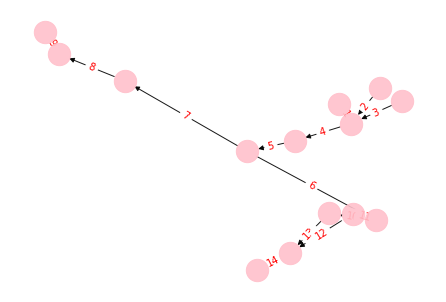

In [7]:
route_graph = route_graphs[111]

"""
for node in route_graph.nodes():
    route_graph.node[node]['label'] = node

edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['sequence_number'] 

for edge in route_graph.edges():
    route_graph.edges[edge]['label'] = edge_labels[edge]

# export as graphML file, see below
nx.write_graphml(route_graph, "graph-111"+".graphml")
"""
edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    
    edge_labels[(node1, node2)] = data['edge_data']['sequence_number']
    
# draw directly from networkx
pos = nx.spring_layout(route_graph)
nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
plt.show()

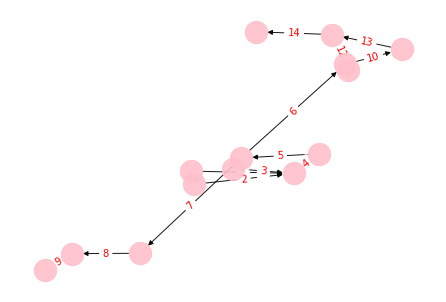

In [8]:
route_graph = route_graphs[113]

"""
for node in route_graph.nodes():
    route_graph.node[node]['label'] = node

edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['sequence_number'] 

for edge in route_graph.edges():
    route_graph.edges[edge]['label'] = edge_labels[edge]

# export as graphML file, see below
nx.write_graphml(route_graph, "graph-111"+".graphml")
"""
edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):
    edge_labels[(node1, node2)] = data['edge_data']['sequence_number']

# draw directly from networkx
pos = nx.spring_layout(route_graph)
nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
plt.show()

### Find all admissible routes

In [9]:
paths = {}
for si in service_intentions:
    startnodes=[]
    endnodes = []
    G = route_graphs[si]
    for edge in G.edges(data=True):
        if 'start_end' in edge[2]['edge_data']:
            if edge[2]['edge_data']['start_end'] == 'start':
                startnodes.append(edge[0])
            if edge[2]['edge_data']['start_end'] == 'end':
                endnodes.append(edge[1])
    paths_si = []
    for s in startnodes:
        for e in endnodes:
            for path in nx.all_simple_paths(G, source=s, target=e):
                paths_si.append([(path[i], path[i+1]) for i in range(len(path)-1)])
    paths[si] = paths_si

In [10]:
si_list = []
for si in paths:
    pathlist = []
    for i,path in enumerate(paths[si]):
        srlist = []
        for sr in path:
            srlist.append((si,i,sr))
        pathlist.append(srlist)
    si_list.append(pathlist)

In [11]:
si_list

[[[(111, 0, ('(1_beginning)', '(M1)')),
   (111, 0, ('(M1)', '(4->5)')),
   (111, 0, ('(4->5)', '(M2)')),
   (111, 0, ('(M2)', '(M3)')),
   (111, 0, ('(M3)', '(10->13)')),
   (111, 0, ('(10->13)', '(M4)')),
   (111, 0, ('(M4)', '(14_end)'))],
  [(111, 1, ('(1_beginning)', '(M1)')),
   (111, 1, ('(M1)', '(4->5)')),
   (111, 1, ('(4->5)', '(M2)')),
   (111, 1, ('(M2)', '(M3)')),
   (111, 1, ('(M3)', '(11->12)')),
   (111, 1, ('(11->12)', '(M4)')),
   (111, 1, ('(M4)', '(14_end)'))],
  [(111, 2, ('(1_beginning)', '(M1)')),
   (111, 2, ('(M1)', '(4->5)')),
   (111, 2, ('(4->5)', '(M2)')),
   (111, 2, ('(M2)', '(7->8)')),
   (111, 2, ('(7->8)', '(8->9)')),
   (111, 2, ('(8->9)', '(9_end)'))],
  [(111, 3, ('(2_beginning)', '(M1)')),
   (111, 3, ('(M1)', '(4->5)')),
   (111, 3, ('(4->5)', '(M2)')),
   (111, 3, ('(M2)', '(M3)')),
   (111, 3, ('(M3)', '(10->13)')),
   (111, 3, ('(10->13)', '(M4)')),
   (111, 3, ('(M4)', '(14_end)'))],
  [(111, 4, ('(2_beginning)', '(M1)')),
   (111, 4, ('(M1)',

In [12]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [13]:
t_len = recursive_len(si_list)
x_len = 0
delta_len = 0
for si in service_intentions:
    x_len += len(route_graphs[si].edges)
    delta_len += len(paths[si])
total_length = t_len*2 + x_len + delta_len
total_length

286

### Variables

|t_in| = sum of the length of all service intentions, total number of paths per si and route sections per path  
|t_out| same as t_in  

|x| all service intentions and their route sections

|delta| all service intentions and their paths

$v = [t_{in}, t_{out} , x, \delta]$

#### Minimize objective function

$J(x)=\{ \frac{1}{60} \sum_{SI, R, RS} win_{rs}max(0, 
t_{si,r,rs}^{in} - LatIn_{si,rs}) + wout_{rs} max(0, t_{si,r,rs}^{out} - LatOut_{si,rs}) + p_{si,rs}x_{si,rs} \}$  



#### Subject to

time into a section comes before time out: 


(1)  $t_{si,r,rs}^{in} \leq t_{si,r,rs}^{out}$  

time into next section comes after time out from previous section:  
(2)  $t_{si,r,rs}^{out} \leq t_{si,r,rs+1}^{in}$

if r is the selected path, satisfy minimum running and stopping time:  
(3)  $t_{si,r,rs}^{out} - t_{si,r,rs}^{in} \geq mrt_{si, r, rs} + mst_{si, r, rs} - M(1-\delta_{si,r})$

Earliest in constraint:  
(4)  $t_{si,r,rs}^{in} \geq EarIn_{si,r,rs} - M(1-\delta_{si,r})$  

Earliest out constraint:  
(5)  $t_{si,r,rs}^{out} \geq EarOut_{si,r,rs} - M(1-\delta_{si,r})$

Select only one path to every service:  
(6)  $\sum_{r \in P} \delta_{si,r} = 1$




In [14]:
def str_to_sec(s):
    s=s.split(':')
    return int(s[0])*60*60+int(s[1])*60+int(s[2])

## Modelling approach

In [ ]:
import cvxpy as cp

### Constraints

In [37]:

tin = [cp.Variable()]*t_len
tout = [cp.Variable()]*t_len
#xs = [cp.Variable(integer = True)]*x_len
deltas = [cp.Variable(integer = True)]*delta_len
cs = []

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            tcon = (tin[i]-tout[i] <= 0)
            cs.append(tcon)
            i+=1
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                tcon = (-tin[i+1]+tout[i] <= 0)
                cs.append(tcon)
            i+=1

#load (3)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    
                    tcon = (tin[i] - tout[i] + M*deltas[j] <= M-mst-mrt)
                    cs.append(tcon)
                    
                i+=1
        j+=1
           
#load (4)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                    tcon = (-tin[i] + M*deltas[j] <= M-EarIn)
                    cs.append(tcon)
                    
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    tcon = (-tout[i] + M*deltas[j] <= M-EarOut)
                    cs.append(tcon)
                        
                i+=1
        j+=1


#load (6)
j = 0
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    for r in si:
        tempsum += deltas[j]
        j +=1
    tcon = (tempsum == 1.0)
    cs.append(tcon)
    
            

### Objective function

In [38]:
objective = 0
i = 0
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                objective += float(edge_data['entry_delay_weight'])*cp.maximum(0, tin[i]-str_to_sec(edge_data['entry_latest']))
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                objective += float(edge_data['exit_delay_weight'])*cp.maximum(0, tout[i]-str_to_sec(edge_data['exit_latest']))
            i+=1
i = 0
for si, si_id in zip(si_list, service_intentions):
    for edge in route_graphs[si_id].edges(data=True):
        p = 0
        if 'penalty' in edge[2]['edge_data']:
            p = edge[2]['edge_data']['penalty']
            if p == None:
                p = 0
            else:
                p = float(p)
            #objective += xs[i]*p
        i+=1

### Solver

In [42]:
prob = cp.Problem(cp.Minimize(objective),
                 cs)
prob.solve(solver='ECOS_BB', verbose = True)

Iter	Lower Bound	Upper Bound	Gap

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -2.984e+09  +3e+09  2e-06  6e+00  1e+00  7e+06    ---    ---    1  1  - |  -  - 
 1  +5.302e+04  -2.833e+09  +3e+09  2e-06  7e-02  6e+03  7e+06  0.0521  2e-02   0  0  0 |  0  0
 2  +2.302e+04  -1.694e+08  +2e+08  1e-07  1e-02  1e+03  4e+05  0.9403  1e-04   0  0  0 |  0  0
 3  +1.963e+03  -9.139e+06  +9e+06  7e-09  2e-03  9e+01  2e+04  0.9462  1e-04   0  0  0 |  0  0
 4  +1.220e+02  -3.889e+05  +4e+05  3e-10  8e-05  6e+00  1e+03  0.9575  1e-04   0  0  0 |  0  0
 5  +7.154e+00  -1.759e+04  +2e+04  2e-11  3e-06  4e-01  4e+01  0.9549  1e-04   0  0  0 |  0  0
 6  +3.347e-01  -6.398e+02  +6e+02  1e-12  1e-07  2e-02  2e+00  0.9637  1e-04   0  0  0 |  0  0
 7  +1.545e-02  -2.437e+01  +2e+01  6e-14  4e-09  8e-04  6e-02  0.9620  1e-04   0  0  0 |  0  0
 8  +3.347e-0

 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.004349 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.960

 7  +6.229e+06  -1.171e+08  +4e+07  1e-05  7e-06  3e+05  9e+04  0.6234  6e-01   1  0  1 |  0  0
 8  +2.080e+07  -5.885e+07  +8e+06  6e-06  3e-06  6e+05  2e+04  0.7986  2e-02   1  1  1 |  0  0
 9  +5.744e+08  +5.143e+08  +5e+05  5e-06  3e-06  1e+07  1e+03  0.9890  4e-02   1  1  1 |  0  0
10  +4.495e+10  +4.572e+10  +6e+03  6e-06  3e-06  8e+08  2e+01  0.9890  1e-04   2  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=3.1e-10).
Runtime: 0.002996 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.7243  2e-01   1  1  1 |  0  0
 3  +1.104e+02  -2.722e+04  +2e+04  2e-03  2e-01  3e+01  4e+01  0.613

 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.8352  1e-01   1  1  1 |  0  0
 7  +6.062e+07  +6.127e+07  +2e+01  2e-02  1e-01  9e+05  5e-02  0.7157  6e-02   2  1  1 |  0  0
 8  +8.916e+08  +9.027e+08  +2e+00  2e-02  1e-01  1e+07  4e-03  0.9890  7e-02   2  1  1 |  0  0
 9  +8.112e+10  +8.215e+10  +2e-02  2e-02  1e-01  1e+09  5e-05  0.9890  1e-04   1  1  1 |  0  0
10  +7.342e+12  +7.435e+12  +2e-04  2e-02  1e-01  9e+10  6e-07  0.9890  1e-04   4  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=2.7e-10).
Runtime: 0.004762 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. W

 7  +3.379e+06  +3.729e+06  +3e+00  3e-03  9e-03  4e+05  8e-03  0.9856  7e-02   1  1  1 |  0  0
 8  +3.532e+07  +3.645e+07  +9e-01  3e-03  1e-02  1e+06  2e-03  0.8846  2e-01   2  1  1 |  0  0
 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.003678 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.723

 2  +1.810e+04  -6.725e+07  +7e+07  7e-05  1e-02  6e+02  2e+05  0.9502  1e-04   0  0  0 |  0  0
 3  +3.708e+04  -6.710e+07  +7e+07  2e-04  3e-03  2e+03  2e+05  0.0128  5e-01   0  0  0 |  0  0
 4  +8.891e+04  -6.671e+07  +7e+07  3e-05  1e-03  5e+03  2e+05  0.0340  5e-01   0  0  0 |  0  0
 5  +3.033e+05  -6.525e+07  +6e+07  8e-06  3e-04  2e+04  2e+05  0.1335  5e-01   0  0  0 |  0  0
 6  +9.275e+05  -6.353e+07  +5e+07  6e-06  5e-05  5e+04  1e+05  0.3180  6e-01   0  0  0 |  0  0
 7  +6.229e+06  -1.171e+08  +4e+07  1e-05  7e-06  3e+05  9e+04  0.6234  6e-01   1  0  1 |  0  0
 8  +2.080e+07  -5.885e+07  +8e+06  6e-06  3e-06  6e+05  2e+04  0.7986  2e-02   1  1  1 |  0  0
 9  +5.744e+08  +5.143e+08  +5e+05  5e-06  3e-06  1e+07  1e+03  0.9890  4e-02   1  1  1 |  0  0
10  +4.495e+10  +4.572e+10  +6e+03  6e-06  3e-06  8e+08  2e+01  0.9890  1e-04   2  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=3.1e-10).
Runtime: 0.003589 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. W

 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.8352  1e-01   1  1  1 |  0  0
 7  +6.062e+07  +6.127e+07  +2e+01  2e-02  1e-01  9e+05  5e-02  0.7157  6e-02   2  1  1 |  0  0
 8  +8.916e+08  +9.027e+08  +2e+00  2e-02  1e-01  1e+07  4e-03  0.9890  7e-02   2  1  1 |  0  0
 9  +8.112e+10  +8.215e+10  +2e-02  2e-02  1e-01  1e+09  5e-05  0.9890  1e-04   1  1  1 |  0  0
10  +7.342e+12  +7.435e+12  +2e-04  2e-02  1e-01  9e+10  6e-07  0.9890  1e-04   4  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=2.7e-

10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.003780 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.835

 4  +5.560e+04  -2.659e+06  +2e+04  3e-01  1e+00  5e+03  4e+01  0.0875  9e-01   1  0  0 |  0  0
 5  +2.505e+04  -3.228e+04  +8e+02  7e-03  2e-02  4e+03  2e+00  0.9890  4e-02   1  1  1 |  0  0
 6  +5.068e+05  +5.277e+05  +4e+01  6e-03  2e-02  8e+04  9e-02  0.9546  1e-04   1  0  0 |  0  0
 7  +3.379e+06  +3.729e+06  +3e+00  3e-03  9e-03  4e+05  8e-03  0.9856  7e-02   1  1  1 |  0  0
 8  +3.532e+07  +3.645e+07  +9e-01  3e-03  1e-02  1e+06  2e-03  0.8846  2e-01   2  1  1 |  0  0
 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.003536 seconds.

302 	44952866497.90 		inf 		inf

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.861e+01  -1.492e+09  +1e+09  1e


PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.003886 seconds.

339 	44952866497.90 		inf 		inf

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.861e+01  -1.492e+09  +1e+09  1e-03  6e+00  1e+00  4e+06    ---    ---    1  1  - |  -  - 
 1  +5.054e+04  -1.348e+09  +1e+09  1e-03  8e-02  6e+03  3e+06  0.0991  2e-02   0  0  0 |  0  0
 2  +1.810e+04  -6.725e+07  +7e+07  7e-05  1e-02  6e+02  2e+05  0.9502  1e-04   0  0  0 |  0  0
 3  +3.708e+04  -6.710e+07  +7e+07  2e-04  3e-03  2e+03  2e+05  0.0128  5e-01   0  0  0 |  0  0
 4  +8.891e+04  -6.671e+07  +7e+07  3e-05  1e-03  5e+03  2e+05  0.0340  5e-01   0  0  0 |  0  0
 5  +3.033e+05  -6.525e+07  +6e+07  8e-06  3e-04  2e+04  2e+05  0.1335  5e-01   0  0  0 |  0  0
 6  +9.275e+05  -6.353e+07  +5e+07  6e-06  5e-05  5e+04  1e+05  0.3180  6e-01   0  0  0 |  0  0
 7  +6.229e+06  -1.171e+08  +4e+07  1

 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.004226 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.960

 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.011185 seconds.

398 	44952866497.90 		inf 		inf

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.861e+01  -1.492e+09  +1e+09  1e-03  6e+00  1e+00  4e+06    ---    ---    1  1  - |  -  - 
 1  +5.054e+04  -1.348e+09  +1e+09  1e-03  8e-02  6e+03  3e+06  0.0991  2e-02   0  0  0 |  0  0
 2  +1.810e+04  -6.725e+07  +7e+07  7e-05  1e-02  6e+02  2e+05  0.9502  1e-04   0  0  0 |  0  0
 3  +3.708e+04  -6.710e+07  +7e+07  2e-04  3e-03  2e+03  2e+05  0.0128  5e-01   0  0  0 |  0  0
 4  +8.891e+04  -6.671e+07  +7e+07  3e-05  1e-03  5e+03  2e+05  0.0340  5e-01   0  0  0 |  0  0
 5  +3.033e+05  -6.525e+07  +6e+07  8

10  +4.495e+10  +4.572e+10  +6e+03  6e-06  3e-06  8e+08  2e+01  0.9890  1e-04   2  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=3.1e-10).
Runtime: 0.002625 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.7243  2e-01   1  1  1 |  0  0
 3  +1.104e+02  -2.722e+04  +2e+04  2e-03  2e-01  3e+01  4e+01  0.6133  9e-02   1  0  1 |  0  0
 4  +5.560e+04  -2.659e+06  +2e+04  3e-01  1e+00  5e+03  4e+01  0.0875  9e-01   1  0  0 |  0  0
 5  +2.505e+04  -3.228e+04  +8e+02  7e-03  2e-02  4e+03  2e+00  0.9890  4e-02   1  1  1 |  0  0
 6  +5.068e+05  +5.277e+05  +4e+01  6e-03  2e-02  8e+04  9e-02  0.954

10  +4.495e+10  +4.572e+10  +6e+03  6e-06  3e-06  8e+08  2e+01  0.9890  1e-04   2  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=3.1e-10).
Runtime: 0.003360 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.7243  2e-01   1  1  1 |  0  0
 3  +1.104e+02  -2.722e+04  +2e+04  2e-03  2e-01  3e+01  4e+01  0.6133  9e-02   1  0  1 |  0  0
 4  +5.560e+04  -2.659e+06  +2e+04  3e-01  1e+00  5e+03  4e+01  0.0875  9e-01   1  0  0 |  0  0
 5  +2.505e+04  -3.228e+04  +8e+02  7e-03  2e-02  4e+03  2e+00  0.9890  4e-02   1  1  1 |  0  0
 6  +5.068e+05  +5.277e+05  +4e+01  6e-03  2e-02  8e+04  9e-02  0.954


It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.7243  2e-01   1  1  1 |  0  0
 3  +1.104e+02  -2.722e+04  +2e+04  2e-03  2e-01  3e+01  4e+01  0.6133  9e-02   1  0  1 |  0  0
 4  +5.560e+04  -2.659e+06  +2e+04  3e-01  1e+00  5e+03  4e+01  0.0875  9e-01   1  0  0 |  0  0
 5  +2.505e+04  -3.228e+04  +8e+02  7e-03  2e-02  4e+03  2e+00  0.9890  4e-02   1  1  1 |  0  0
 6  +5.068e+05  +5.277e+05  +4e+01  6e-03  2e-02  8e+04  9e-02  0.9546  1e-04   1  0  0 |  0  0
 7  +3.379e+06  +3.729e+06  +3e+00  3e-03  9e-03  4e+05  8e-03  0.9856  7e-02   1  1  1 |  0  0
 8  +3.532e+07  +3.645e+07  +9e-01  3e-03  1e-02  1e+06  2e-03  0.8846  2e-01   2  1  1 |  0  0
 9  +1.139e+09  +1.171e+09  +4e-02  3e-

Runtime: 0.001076 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.8352  1e-01   1  1  1 |  0  0
 7  +6.062e+07  +6.127e+07  +2e+01  2e-02  1e-01  9e+05  5e-02  0.7157  6e-02   2  1  1 |  0  0
 8  +8.916e+08  +9

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7  +6.229e+06  -1.171e+08  +4e+07  1e-05  7e-06  3e+05  9e+04  0.6234  6e-01   1  0  1 |  0  0
 8  +2.080e+07  -5.885e+07  +8e+06  6e-06  3e-06  6e+05  2e+04  0.7986  2e-02   1  1  1 |  0  0
 9  +5.744e+08  +5.143e+08  +5e+05  5e-06  3e-06  1e+07  1e+03  0.9890  4e-02   1  1  1 |  0  0
10  +4.495e+10  +4.572e+10  +6e+03  6e-06  3e-06  8e+08  2e+01  0.9890  1e-04   2  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=3.1e-10).
Runtime: 0.003504 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.7243  2e-01   1  1  1 |  0  0
 3  +1.104e+02  -2.722e+04  +2e+04  2e-03  2e-01  3e+01  4e+01  0.613

 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.7243  2e-01   1  1  1 |  0  0
 3  +1.104e+02  -2.722e+04  +2e+04  2e-03  2e-01  3e+01  4e+01  0.6133  9e-02   1  0  1 |  0  0
 4  +5.560e+04  -2.659e+06  +2e+04  3e-01  1e+00  5e+03  4e+01  0.0875  9e-01   1  0  0 |  0  0
 5  +2.505e+04  -3.228e+04  +8e+02  7e-03  2e-02  4e+03  2e+00  0.9890  4e-02   1  1  1 |  0  0
 6  +5.068e+05  +5.277e+05  +4e+01  6e-03  2e-02  8e+04  9e-02  0.9546  1e-04   1  0  0 |  0  0
 7  +3.379e+06  +3.729e+06  +3e+00  3e-03  9e-03  4e+05  8e-03  0.9856  7e-02   1  1  1 |  0  0
 8  +3.532e+07  +3.645e+07  +9e-01  3e-03  1e-02  1e+06  2e-03  0.8846  2e-01   2  1  1 |  0  0
 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-

 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.8352  1e-01   1  1  1 |  0  0
 7  +6.062e+07  +6.127e+07  +2e+01  2e-02  1e-01  9e+05  5e-02  0.7157  6e-02   2  1  1 |  0  0
 8  +8.916e+08  +9.027e+08  +2e+00  2e-02  1e-01  1e+07  4e-03  0.9890  7e-02   2  1  1 |  0  0
 9  +8.112e+10  +8.215e+10  +2e-02  2e-02  1e-01  1e+09  5e-05  0.9890  1e-04   1  1  1 |  0  0
10  +7.342e+12  +7.435e+12  +2e-04  2e-02  1e-01  9e+10  6e-07  0.9890  1e-04   4  2  2 |  0  0

PRIMAL INFEASIBLE (within feastol=2.7e-10).
Runtime: 0.004411 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.003e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.774e+02  -1.404e+05  +9e+04  1e-02  8e-01  8e+01  2e+02  0.8558  1e-01   1  1  1 |  0  0
 2  +2.023e+02  -6.257e+04  +4e+04  5e-03  5e-01  6e+01  9e+01  0.724

10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.003435 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.835


It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.8352  1e-01   1  1  1 |  0  0
 7  +6.062e+07  +6.127e+07  +2e+01  2e-02  1e-01  9e+05  5e-02  0.7157  6e-02   2  1  1 |  0  0
 8  +8.916e+08  +9.027e+08  +2e+00  2e-02  1e-01  1e+07  4e-03  0.9890  7e-02   2  1  1 |  0  0
 9  +8.112e+10  +8.215e+10  +2e-02  2e-

 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.9601  2e-04   1  1  0 |  0  0
 6  +1.677e+07  +1.682e+07  +6e+01  2e-02  1e-01  3e+05  2e-01  0.8352  1e-01   1  1  1 |  0  0
 7  +6.062e+07  +6.127e+07  +2e+01  2e-02  1e-01  9e+05  5e-02  0.7157  6e-02   2  1  1 |  0  0
 8  +8.916e+08  +9.027e+08  +2e+00  2e-02  1e-01  1e+07  4e-03  0.9890  7e-02   2  1  1 |  0  0
 9  +8.112e+10  +8.215e+10  +2e-02  2e-02  1e-01  1e+09  5e-05  0.9890  1e-04   1  1  1 |  0  0
10  +7.342e+12  +7.435e+12  +2e-04  2e-

 9  +1.139e+09  +1.171e+09  +4e-02  3e-03  1e-02  3e+07  9e-05  0.9833  2e-02   2  1  1 |  0  0
10  +1.138e+11  +1.170e+11  +5e-04  4e-03  2e-02  3e+09  1e-06  0.9876  1e-04   4  3  3 |  0  0

PRIMAL INFEASIBLE (within feastol=5.4e-10).
Runtime: 0.003491 seconds.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.403e+01  -7.001e+05  +3e+05  5e-02  6e+00  1e+00  9e+02    ---    ---    1  1  - |  -  - 
 1  -3.174e+02  -2.201e+05  +1e+05  2e-02  1e+00  7e+01  3e+02  0.7049  1e-01   1  1  1 |  0  0
 2  +1.970e+02  -3.390e+05  +1e+05  3e-02  5e-01  1e+02  3e+02  0.0315  9e-01   1  0  0 |  0  0
 3  +1.277e+04  -6.698e+05  +8e+04  7e-02  7e-01  9e+02  2e+02  0.7237  4e-01   1  1  0 |  0  0
 4  +6.853e+04  -1.668e+05  +6e+03  3e-02  2e-01  3e+03  1e+01  0.9369  1e-02   1  1  1 |  0  0
 5  +1.806e+06  +1.644e+06  +2e+02  2e-02  2e-01  7e+04  5e-01  0.960

In [41]:
for tag,v in zip(['tin', 'tout', 'x', 'delta'],[tin, tout, xs, deltas]):
    for e in v:
        print(tag, e.value)

tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
tin None
t

## Appendix

### Matrix approach

In [15]:

A = np.array([])
b = []

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            temp = np.zeros(total_length)
            temp[i] = 1 #tin
            temp[i+t_len] = -1 #tout
            b.append(0)
            i+=1
            if len(A)==0:
                A = temp
            else:
                A = np.vstack((A,temp))
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                temp = np.zeros(total_length)
                temp[i+1] = -1 #tin
                temp[i+t_len] = 1 #tout
                b.append(0)

                if len(A)==0:
                    A = temp
                else:
                    A = np.vstack((A,temp))
            i+=1

#load (3)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    temp = np.zeros(total_length)
                    temp[i] = 1 #tin
                    temp[i+t_len+1] = -1 #tout
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-mst-mrt)
                    
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
        
print(j)        
#load (4)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                        
                    temp = np.zeros(total_length)
                    temp[i] = -1 #tin
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-EarIn)
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    temp = np.zeros(total_length)
                    temp[i + t_len] = -1 #tin
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-EarOut)
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
b = np.array(b).astype('float64')
c = np.array([1.0]*total_length)

18
